In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import psycopg2
import re

# settings
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,}'.format
%matplotlib inline

# database
conn_string = open('./intern/DB_connection.txt', 'r', encoding='UTF-8').read()

# Database

In [2]:
conn = eval('psycopg2.connect({})'.format(conn_string.strip()))

In [3]:
sql = """select * from vw_t_chartevents LIMIT 1000"""
df_sql = pd.read_sql(sql, conn)

In [4]:
df_sql.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,15639,111.0,"155,897.0","249,202.0","225,668.0",2144-07-01 04:18:00,2144-07-01 04:25:00,"20,889.0",3.2,3.2,mmol/L,1.0,0.0,None,None
1,15640,111.0,"155,897.0","249,202.0","220,224.0",2144-07-01 07:31:00,2144-07-01 07:34:00,"20,889.0",159,159.0,mmHg,1.0,0.0,None,None
2,15641,111.0,"155,897.0","249,202.0","220,235.0",2144-07-01 07:31:00,2144-07-01 07:34:00,"20,889.0",81,81.0,mmHg,1.0,0.0,None,None
3,15642,111.0,"155,897.0","249,202.0","223,830.0",2144-07-01 07:31:00,2144-07-01 07:34:00,"20,889.0",6.98,6.98,units,1.0,0.0,None,None
4,15643,111.0,"155,897.0","249,202.0","224,828.0",2144-07-01 07:31:00,2144-07-01 07:34:00,"20,889.0",-14,-14.0,mEq/L,0.0,0.0,None,None


In [4]:
df_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
row_id          1000 non-null int64
subject_id      1000 non-null float64
hadm_id         1000 non-null float64
icustay_id      1000 non-null float64
itemid          1000 non-null float64
charttime       1000 non-null datetime64[ns]
storetime       1000 non-null datetime64[ns]
cgid            1000 non-null float64
value           1000 non-null object
valuenum        1000 non-null float64
valueuom        939 non-null object
warning         1000 non-null float64
error           1000 non-null float64
resultstatus    0 non-null object
stopped         0 non-null object
dtypes: datetime64[ns](2), float64(8), int64(1), object(4)
memory usage: 117.3+ KB


# inputevents_cv

Inputs are any fluids which have been administered to the patient: such as oral or tube feedings or intravenous solutions containing medications. 

Inputs exist in two separate tables: INPUTEVENTS_CV and INPUTEVENTS_MV. INPUTEVENTS_CV contains CareVue inputs, while INPUTEVENTS_MV contains Metavision inputs. Results from these tables can be unioned as observations are not duplicated across tables. For CareVue data, the rate and volume will be asynchronous, and only the CHARTTIME will be available. For rates, the CHARTTIME will correspond to a start time (when the drug was set to that rate). For volumes, the CHARTTIME will correspond to an end time.

| column | Description | Type |
|:-------|:------------|------|
| ROW_ID | ID from Database | numeric |
| SUBJECT_ID | Unique ID of a patient | numeric |
| HADM_ID | Unique ID of a patient hospital stay | numeric |
| ICUSTAY_ID | Unique ID of a patient ICU stay | numeric |
| CHARTTIME | time at which the measurement was charted at the bedside | datetime |
| ITEMID | Identifier for a single measurement type D_ITEMS.csv | numeric |
| AMOUNT | amount of a drug or substance administered to the patient either between the STARTTIME and ENDTIME | numeric |

In [5]:
sql = """select * from inputevents_cv 
        where subject_id in (select subject_id from diagnoses_icd di where ICD9_CODE = '51881')
        LIMIT 100000"""
df_input_cv = pd.read_sql(sql, conn)

In [7]:
df_input_cv.shape

(100000, 22)

In [8]:
df_input_cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
row_id               100000 non-null int64
subject_id           100000 non-null int64
hadm_id              99685 non-null float64
icustay_id           99578 non-null float64
charttime            100000 non-null datetime64[ns]
itemid               100000 non-null int64
amount               99081 non-null float64
amountuom            99195 non-null object
rate                 0 non-null object
rateuom              0 non-null object
storetime            100000 non-null datetime64[ns]
cgid                 100000 non-null int64
orderid              100000 non-null int64
linkorderid          100000 non-null int64
stopped              863 non-null object
newbottle            343 non-null float64
originalamount       58655 non-null float64
originalamountuom    100000 non-null object
originalroute        100000 non-null object
originalrate         7 non-null float64
originalrateuom     

We can see that already in the first 100000 rows some HADM_ID's are missing. Let us show how many, if we import only this column.

In [9]:
sql = """select hadm_id from inputevents_cv """
df_test = pd.read_sql(sql, conn)

In [10]:
df_test.shape

(17527935, 1)

In [11]:
df_test.isna().sum()

hadm_id    22669
dtype: int64

In [12]:
print('Missing HADM_ID in percent: {:.2f}%'.format(float(df_test.isna().sum()) / df_test.shape[0] *100))

Missing HADM_ID in percent: 0.13%


The amount of missing HADM_ID's ist tiny. We ignore these missing entrys.

In [13]:
df_input_cv.head()

,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,storetime,cgid,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,237,19872,"134,153.0","249,265.0",2106-08-24 00:00:00,30056,60.0,ml,None,None,2106-08-24 00:34:00,17155,11574865,5492089,None,nan,nan,ml,Oral,nan,None,None
1,238,19872,"134,153.0","249,265.0",2106-08-24 06:00:00,30056,60.0,ml,None,None,2106-08-24 05:58:00,17155,7339140,5492089,None,nan,nan,ml,Oral,nan,None,None
2,239,19872,"134,153.0","249,265.0",2106-08-24 08:00:00,30056,200.0,ml,None,None,2106-08-24 13:31:00,19525,4310986,5492089,None,nan,nan,ml,Oral,nan,None,None
3,240,19872,"134,153.0","249,265.0",2106-08-24 10:00:00,30056,100.0,ml,None,None,2106-08-24 13:31:00,19525,10773658,5492089,None,nan,nan,ml,Oral,nan,None,None
4,241,19872,"134,153.0","249,265.0",2106-08-24 13:00:00,30056,200.0,ml,None,None,2106-08-24 14:38:00,19525,6089121,5492089,None,nan,nan,ml,Oral,nan,None,None


In [14]:
sql = """select row_id from inputevents_cv """
df_test2 = pd.read_sql(sql, conn)

In [15]:
df_test2.shape

(17527935, 1)

In [16]:
df_test2.nunique()

row_id    17527935
dtype: int64

# Find extubations

In [6]:
sql = """select i2.hadm_id, v.* 
        from ventsettings v
        inner join icustays i2 on i2.icustay_id = v.icustay_id 
        where (v.mechvent + v.oxygentherapy + v.extubated + v.selfextubated) > 0
            and i2.hadm_id in (select * from hadm_overview) 
        order by icustay_id, charttime """
df = pd.read_sql(sql, conn)

In [7]:
df.shape

(592571, 7)

In [19]:
df.head(3)

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592571 entries, 0 to 592570
Data columns (total 7 columns):
hadm_id          592571 non-null int64
icustay_id       592571 non-null float64
charttime        592571 non-null datetime64[ns]
mechvent         592571 non-null int64
oxygentherapy    592571 non-null int64
extubated        592571 non-null int64
selfextubated    592571 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 31.6 MB


This dataframe contains all entries from the table chartevents of the selected hadm_id's. We have to find the timestamp of the extubations and we have to check if the first extubation is succesfull.

## Getting the timestamp

Checking the exturbations

In [8]:
df_count_ex = df.groupby('icustay_id').extubated.sum()

In [9]:
df_count_ex.head()

icustay_id
200,006.0    0
200,059.0    0
200,063.0    4
200,065.0    1
200,077.0    0
Name: extubated, dtype: int64

In [10]:
df[(df.extubated == 1)].shape

(4960, 7)

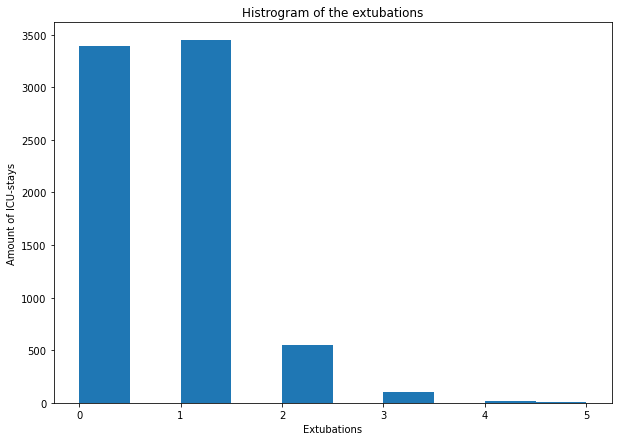

In [24]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.hist(df_count_ex)
plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Histrogram of the extubations')
plt.savefig('./images/hist_extubations_per_icustay.png')
plt.show();

In [11]:
icustay_ids = df['icustay_id'].unique()

In [12]:
sql = """select distinct icustay_id 
        from vw_extubations ve 
        where extubated = 1"""
df_icu_ext = pd.read_sql(sql, conn)

In [47]:
print(f'Documentation of extubations: {df_icu_ext.shape[0] / len(icustay_ids) * 100:.1f} %')

Documentation of extubations: 54.9 %


Many ICU stays have no explicit documented extubation. We need to extract the id's and find another way.

In [25]:
# Building the difference for each row in 'mechvent' to get 
sql = """SELECT i2.hadm_id,
            v.icustay_id,
            v.charttime,
            v.mechvent,
            v.oxygentherapy,
            v.extubated,
            v.selfextubated,
            v.mechvent - lag(v.mechvent, 1) OVER (PARTITION BY v.icustay_id ORDER BY v.icustay_id, v.charttime) AS ex
          FROM ventsettings v
          JOIN icustays i2 ON i2.icustay_id::numeric = v.icustay_id
          WHERE (v.mechvent + v.oxygentherapy + v.extubated + v.selfextubated) > 0 
              AND (i2.hadm_id IN ( SELECT hadm_overview.hadm_id FROM hadm_overview))"""
df_extub = pd.read_sql(sql, conn)

In [26]:
df_extub.shape

(592571, 8)

In [27]:
df_extub.head()

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0,nan
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0,0.0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0,0.0
3,189514,"200,006.0",2159-09-03 23:30:00,1,0,0,0,0.0
4,189514,"200,006.0",2159-09-04 03:50:00,1,0,0,0,0.0


Now we have a new column 'ex'. If the value of 'mechvent' fall from 1 to 0, we get a -1, otherwise we get a +1. Now we can use the timestamp where ex is -1 as our extubation timestamp.

Saving that query as view: `vw_extubations`. <br>
[vw_extubations]('data/04_changes_mechvent.sql)

In [28]:
# Check the new column versus the documented extubations.
sql = """select * 
        from vw_extubations ve
        where ve.icustay_id in (select distinct icustay_id 
                                from vw_extubations ve 
                                where extubated = 1)
            and ve.extubated = 1
            and ve.ex <> -1
        order by ve.icustay_id, ve.charttime"""
df_check_ext1 = pd.read_sql(sql, conn)

In [29]:
df_check_ext1.head(5)

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
0,129142,"200,063.0",2141-03-24 17:30:00,0,0,1,0,0
1,159163,"200,203.0",2140-04-07 13:27:00,0,0,1,0,0
2,142755,"200,240.0",2147-10-28 08:00:00,0,0,1,0,0
3,176395,"200,282.0",2164-05-15 10:05:00,0,0,1,0,0
4,199655,"200,647.0",2116-07-02 11:08:00,0,0,1,0,0


In [30]:
df_check_ext1.shape

(1244, 8)

Of 4,960 documented extubations, we cannot determine the expected flag by 1,244 entries as expected. For a better understanding we get a closer look to some single icustay_id.

In [31]:
df_extub[(df.icustay_id == 200203)].sort_values(by='charttime')

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
1162,159163,"200,203.0",2140-04-06 22:00:00,1,0,0,0,nan
1163,159163,"200,203.0",2140-04-07 00:00:00,1,0,0,0,0.0
1164,159163,"200,203.0",2140-04-07 04:00:00,1,0,0,0,0.0
1165,159163,"200,203.0",2140-04-07 04:07:00,1,0,0,0,0.0
1166,159163,"200,203.0",2140-04-07 08:00:00,1,0,0,0,0.0
1167,159163,"200,203.0",2140-04-07 12:00:00,1,0,0,0,0.0
1168,159163,"200,203.0",2140-04-07 13:03:00,0,1,0,0,-1.0
1169,159163,"200,203.0",2140-04-07 13:27:00,0,0,1,0,0.0
1170,159163,"200,203.0",2140-04-07 16:00:00,0,1,0,0,0.0
1171,159163,"200,203.0",2140-04-08 00:00:00,0,1,0,0,0.0


As you can see, the oxygentherapy has been documented here first and then the extubation. Due to the temporal proximity and the presumably dynamic documentation of an intensive care unit, the end of mechanical ventilation is determined as extubation. The time is needed to extract the last data before the extubation from the table chartevents. Therefore, a very precise time is not decisive here.

In [32]:
df_extub[(df.icustay_id == 200006)].sort_values(by='charttime')

,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated,ex
0,189514,"200,006.0",2159-09-03 13:00:00,1,0,0,0,nan
1,189514,"200,006.0",2159-09-03 16:50:00,1,0,0,0,0.0
2,189514,"200,006.0",2159-09-03 20:00:00,1,0,0,0,0.0
3,189514,"200,006.0",2159-09-03 23:30:00,1,0,0,0,0.0
4,189514,"200,006.0",2159-09-04 03:50:00,1,0,0,0,0.0
5,189514,"200,006.0",2159-09-04 07:00:00,0,1,0,0,-1.0
6,189514,"200,006.0",2159-09-04 11:00:00,0,1,0,0,0.0
7,189514,"200,006.0",2159-09-04 17:00:00,0,1,0,0,0.0


Considering the creation of the table 'vent_settings', which indicates the beginning of oxygen therapy the ventilation has ended, the column 'extubated' is not complete.

In [33]:
# Creating query for extubation timestamps
sql = """select distinct i2.hadm_id, ve.icustay_id, ve.charttime
        from vw_extubations ve 
        inner JOIN icustays i2 ON i2.icustay_id::numeric = ve.icustay_id
        where ve.ex = -1
        group by i2.hadm_id, ve.icustay_id, ve.charttime
        order by ve.icustay_id"""
df_extub_time = pd.read_sql(sql, conn)

In [34]:
df_extub_time.head()

,hadm_id,icustay_id,charttime
0,189514,"200,006.0",2159-09-04 07:00:00
1,199133,"200,059.0",2198-02-17 14:30:00
2,199133,"200,059.0",2198-02-17 19:00:00
3,199133,"200,059.0",2198-02-18 11:15:00
4,199133,"200,059.0",2198-02-19 07:32:00


Some icustay's includes more than one extubation. Saving that query as: `vw_timestamp_extubation`

## Create the label

In order to determine the success of the first extubation, we need its time and, if available, also the first intubation. For the classification we also need the time between ex- and intubation. 

In [50]:
# Calculated the time between extubation and the next possible intubation in hours
# and axtract the first changes of mechanical ventilation
sql = """SELECT ve.hadm_id, ve.icustay_id, intub.ts_intubation, min(ve.charttime) AS ts_extubation,
	round(date_part('epoch', (min(ve.charttime) - intub.ts_intubation) / 3600)::numeric,2) as hour_mechvent,
	re_intub.ts_re_intubation,
	round(date_part('epoch', (re_intub.ts_re_intubation - min(ve.charttime)) / 3600)::numeric,2) as hour_to_reintub
FROM vw_extubations ve
Left join (SELECT ve.icustay_id, min(ve.charttime) AS ts_intubation
			FROM vw_extubations ve
			where ve.mechvent = 1
			GROUP BY ve.icustay_id) intub on ve.icustay_id = intub.icustay_id
left join (SELECT ve.icustay_id, min(ve.charttime) AS ts_re_intubation
			FROM vw_extubations ve
			LEFT join (SELECT ve.icustay_id, min(ve.charttime) AS ts_extubation
						FROM vw_extubations ve
						Left join (SELECT ve.icustay_id, min(ve.charttime) AS ts_intubation
							FROM vw_extubations ve
							where ve.mechvent = 1
							GROUP BY ve.icustay_id) intub on ve.icustay_id = intub.icustay_id
						where ve.mechvent = 0 and ve.ex = -1
						GROUP BY ve.icustay_id, intub.ts_intubation) ext on ve.icustay_id = ext.icustay_id
			where ve.mechvent = 1 and ve.charttime > ext.ts_extubation
			GROUP BY ve.icustay_id) re_intub on ve.icustay_id = re_intub.icustay_id
where ve.mechvent = 0 and ve.ex = -1
GROUP BY ve.hadm_id, ve.icustay_id, intub.ts_intubation, re_intub.ts_re_intubation
order by ve.icustay_id """
df_ex_ts = pd.read_sql(sql, conn)

In [51]:
df_ex_ts.head()

,hadm_id,icustay_id,ts_intubation,ts_extubation,hour_mechvent,ts_re_intubation,hour_to_reintub
0,189514,"200,006.0",2159-09-03 13:00:00,2159-09-04 07:00:00,18.0,NaT,nan
1,199133,"200,059.0",2198-02-10 06:00:00,2198-02-17 14:30:00,176.5,2198-02-17 15:00:00,0.5
2,129142,"200,063.0",2141-03-10 07:00:00,2141-03-15 14:09:00,127.15,2141-03-16 09:00:00,18.85
3,112840,"200,065.0",2120-03-22 22:30:00,2120-04-01 10:30:00,228.0,NaT,nan
4,113580,"200,077.0",2163-04-12 08:00:00,2163-04-12 08:30:00,0.5,2163-04-12 13:00:00,4.5


In [52]:
# Add the label: 
# duration betwenn in- or extubation is greater then 48h or nan, then 1
# else 1
sql = """SELECT vte.hadm_id, vte.icustay_id, vte.hour_to_reintub,
	CASE
        WHEN vte.hour_to_reintub IS NULL THEN 1
        WHEN vte.hour_to_reintub > 48::double precision THEN 1
        ELSE 0
    END AS label
FROM vw_ts_extubations vte """
df_label_ex = pd.read_sql(sql, conn)

In [53]:
df_label_ex.head()

,hadm_id,icustay_id,hour_to_reintub,label
0,189514,"200,006.0",nan,1
1,199133,"200,059.0",0.5,0
2,129142,"200,063.0",18.85,0
3,112840,"200,065.0",nan,1
4,113580,"200,077.0",4.5,0


Saving this query as `vw_label_extubations`

In [54]:
df_label_ex[(df_label_ex.hour_to_reintub > 48)].hadm_id.count()

257

In [55]:
df_label_ex[(df_label_ex.hour_to_reintub.isna())].hadm_id.count()

3732

In [56]:
df_label_ex[(df_label_ex.label == 0)].hadm_id.count()

1963

In [57]:
df_label_ex.shape

(5952, 4)

In [58]:
df_label_ex.groupby('label').icustay_id.count()

label
0    1963
1    3989
Name: icustay_id, dtype: int64

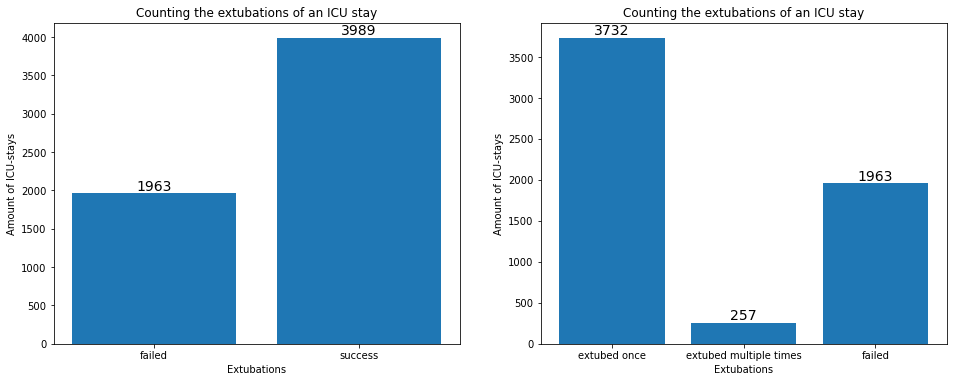

In [59]:
fig = plt.figure(figsize=(16,13))
ax1 = fig.add_subplot(2, 2, 1)
x_val1 = ['failed', 'success']
y_val1 = df_label_ex.groupby('label').icustay_id.count()
ax1.bar(x= x_val1, height=y_val1)
for _, value in enumerate(y_val1):
    plt.text(x_val1[_], value, str(value), fontsize=14,
            horizontalalignment='center', va='bottom')
plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Counting the extubations of an ICU stay')

ax2 = fig.add_subplot(2, 2, 2)
x_val2 = ['extubed once', 'extubed multiple times', 'failed']
y_val2 = [df_label_ex[(df_label_ex.hour_to_reintub.isna())].hadm_id.count(),
         df_label_ex[(df_label_ex.hour_to_reintub > 48)].hadm_id.count(),
         df_label_ex[(df_label_ex.label == 0)].hadm_id.count()]
ax2.bar(x= x_val2, height=y_val2)

for _, value in enumerate(y_val2):
    plt.text(x_val2[_], value, str(value), fontsize=14,
            horizontalalignment='center', va='bottom')

plt.ylabel('Amount of ICU-stays')
plt.xlabel('Extubations')
plt.title('Counting the extubations of an ICU stay')
plt.savefig('./images/label_extubations.png')
plt.show();

In [60]:
df_label_ex.hadm_id.nunique()

5590

In [61]:
df_label_ex.icustay_id.nunique()

5952

Some patients have been successfully extubated more often during their stay in hospital.

# Creating the final queries

## Patient_Group

Create the query to get the static features of entries already found in hadm_overview 

In [62]:
sql = """select * from vw_patient_group"""
df_goal = pd.read_sql(sql, conn)

Saving the query ('.sql/06_view_patients_group.sql') as `vw_patient_group` 

In [63]:
df_goal.shape

(5897, 13)

In [ ]:
df_goal.to_csv('data/patient_group.csv', encoding='UTF-8', index=False)

## Events from labevents

In [64]:
sql = """SELECT l.hadm_id,
    last_val.icustay_id,
    l.itemid,
    l.value,
    last_val.ts,
        CASE
            WHEN l.itemid = 50821 THEN 'Pa02'::text
            WHEN l.itemid = 50802 THEN 'base_excess'::text
            WHEN l.itemid = 50820 THEN 'pH'::text
            WHEN l.itemid = 51222 THEN 'hb'::text
            WHEN l.itemid = 51221 THEN 'hct'::text
            WHEN l.itemid = 50912 THEN 'creatinin'::text
            ELSE NULL::text
        END AS item
   FROM labevents l
     JOIN ( SELECT last_events.hadm_id,
            last_events.icustay_id,
            last_events.itemid,
            max(last_events.charttime) AS ts
           FROM ( SELECT l2.hadm_id,
                    l2.itemid,
                    min_ts.icustay_id,
                    l2.charttime,
                    l2.value
                   FROM labevents l2
                   JOIN ( SELECT vte.hadm_id,
                            vte.icustay_id,
                            min(vte.charttime) AS ext_ts
                           FROM vw_timestamp_extubation vte
                          GROUP BY vte.hadm_id, vte.icustay_id) min_ts ON min_ts.hadm_id = l2.hadm_id AND min_ts.ext_ts > l2.charttime
                  WHERE l2.itemid = ANY (ARRAY[50821, 50802, 50820, 51222, 51221, 50912])) last_events
          GROUP BY last_events.hadm_id, last_events.icustay_id, last_events.itemid) last_val ON last_val.hadm_id = l.hadm_id AND last_val.itemid = l.itemid AND last_val.ts = l.charttime
  ORDER BY l.hadm_id, last_val.icustay_id, l.itemid"""

df_lab = pd.read_sql(sql, conn)

Saving this query under .sql/07_labevents_pre_ext.sql

In [65]:
df_lab.head(13)

,hadm_id,icustay_id,itemid,value,ts,item
0,100016,"217,590.0",50802,2,2188-05-24 17:24:00,base_excess
1,100016,"217,590.0",50820,7.43,2188-05-24 17:24:00,pH
2,100016,"217,590.0",50821,86,2188-05-24 17:24:00,Pa02
3,100016,"217,590.0",50912,1.1,2188-05-28 04:16:00,creatinin
4,100016,"217,590.0",51221,31.1,2188-05-28 04:16:00,hct
5,100016,"217,590.0",51222,10.3,2188-05-28 04:16:00,hb
6,100017,"258,320.0",50802,4,2103-03-11 05:10:00,base_excess
7,100017,"258,320.0",50820,7.52,2103-03-11 05:10:00,pH
8,100017,"258,320.0",50821,171,2103-03-11 05:10:00,Pa02
9,100017,"258,320.0",50912,0.8,2103-03-11 03:05:00,creatinin


In [66]:
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35188 entries, 0 to 35187
Data columns (total 6 columns):
hadm_id       35188 non-null int64
icustay_id    35188 non-null float64
itemid        35188 non-null int64
value         35188 non-null object
ts            35188 non-null datetime64[ns]
item          35188 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.6+ MB


In [ ]:
df_lab.to_csv('data/labevents_pre_extub.csv', encoding='UTF-8', index=False)

## Events from chartevents

Shrink the size of chartevents and an item-name as additioal information. 

In [67]:
sql = """SELECT c.hadm_id, c.icustay_id, c.itemid, c.charttime,
            c.value, c.valuenum, c.valueuom,
            case 
                when c.itemid in (211, 220045) then 'hr' 
                when c.itemid in (52, 456, 225312, 220181, 220052) then 'blood_pr'
                when c.itemid in (676,  677, 223762) then 'temp'
                when c.itemid in (646, 834, 220277, 220227) then 'SaO2'
                when c.itemid in (618 ,  220210 , 224688) then 'resp_rat'
                when c.itemid in (445, 448, 449, 224687, 1340, 1486, 1600) then 'breath_min_vol'
                when c.itemid in (189, 190, 3420, 3422, 223835) then 'FiO2'
                when c.itemid in (681, 682, 683, 684, 224685, 224684, 224686) then 'tidal_vol'
                when c.itemid in (444, 224697) then 'mean_insp_pressure'
                when c.itemid in (506, 220339) then 'PEEP'
                when c.itemid in (1127, 861, 1542, 220546) then 'leuko'
                when c.itemid in (225668, 1531, 818) then 'lactic_acid'
            end as item,
            c.storetime, c.cgid, c.warning , c.error , c.resultstatus , c.stopped 
           FROM chartevents c
          WHERE (c.hadm_id IN (SELECT hadm_overview.hadm_id FROM hadm_overview))
            and c.itemid in (211, 220045,
                            52, 456, 225312, 220181, 220052,
                            676,  677, 223762,
                            646, 834, 220277, 220227,
                            618 ,  220210 , 224688,
                            445, 448, 449, 224687, 1340, 1486, 1600,
                            189, 190, 3420, 3422, 223835,
                            681, 682, 683, 684, 224685, 224684, 224686,
                            444, 224697,
                            506, 220339,
                            1127, 861, 1542, 220546,
                            225668, 1531, 818)"""
df_ce_1 = pd.read_sql(sql, conn)

In [ ]:
df_ce_1.head(10)

Save this query as view `vw_ce_filtered` 

Only entries before extubation je icustay_id are of interest for us, so that the entries are filtered out afterwards.

In [ ]:
sql = """select ce.*
            from vw_ce_filtered ce
            inner join (select hadm_id, icustay_id, min(charttime) as ext_ts
                        from vw_timestamp_extubation vte
                        group by hadm_id, icustay_id) min_ts 
                on (min_ts.icustay_id = ce.icustay_id and min_ts.ext_ts > ce.charttime)
            order by ce.icustay_id, ce.charttime desc"""
df_ce_2 = pd.read_sql(sql, conn)

In [ ]:
df_ce_2.head(10)

From the entries before extubation, we needed for each item the entry that is closest to extubation. Since in a grouping the column value would destroy the grouping, we grab only the columns icustay_id, charttime and item and then connect this result to the view vw_ce_filtered to get the value.

In [ ]:
sql = """select ce.icustay_id, ce.item, max(ce.charttime) as last_ts
            from vw_ce_filtered ce
            inner join (select hadm_id, icustay_id, min(charttime) as ext_ts
                        from vw_timestamp_extubation vte
                        group by hadm_id, icustay_id) min_ts 
                on (min_ts.icustay_id = ce.icustay_id and min_ts.ext_ts > ce.charttime)
            where ce.icustay_id in (245719, 217590)
            group by ce.icustay_id, ce.item 
            order by ce.icustay_id, ce.item"""
df_ce_3 = pd.read_sql(sql, conn)

In [ ]:
df_ce_3.head(13)

From the df_ce_3 result the value matching icustay_id, item and last_ts must now be determined.

In [ ]:
sql = """select distinct vcf.* 
        from vw_ce_filtered vcf 
        inner join (select distinct ce.icustay_id, ce.item, max(ce.charttime) as last_ts
                    from vw_ce_filtered ce
                    inner join (select hadm_id, icustay_id, min(charttime) as ext_ts
                                from vw_timestamp_extubation vte
                                group by hadm_id, icustay_id) min_ts 
                        on (min_ts.icustay_id = ce.icustay_id and min_ts.ext_ts > ce.charttime)
                    group by ce.icustay_id, ce.item) last_events
            on (last_events.icustay_id = vcf.icustay_id and last_events.item = vcf.item and last_events.last_ts = vcf.charttime)
        order by vcf.hadm_id , vcf.icustay_id"""
df_ce = pd.read_sql(sql, conn)

In [ ]:
df_ce.head()

In [ ]:
df_ce.info()

So that the result can be retrieved quickly and repeatedly in the future, we create a new table with the name chartev_values.

In [ ]:
sql = """select * from chartev_values"""
df_ce = pd.read_sql(sql, conn)

In [ ]:
df_ce.to_csv('data/chartevents_pre_extub.csv', encoding='UTF-8', index=False)

In [ ]:
conn.close()